# 時間序列(Time Series)預測 
### 程式修改自 [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

In [52]:
# 載入相關套件
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM, Input, InputLayer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# 載入測試資料
df = pd.read_csv('../nlp_data/airline-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [16]:
df.tail()

,Month,Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


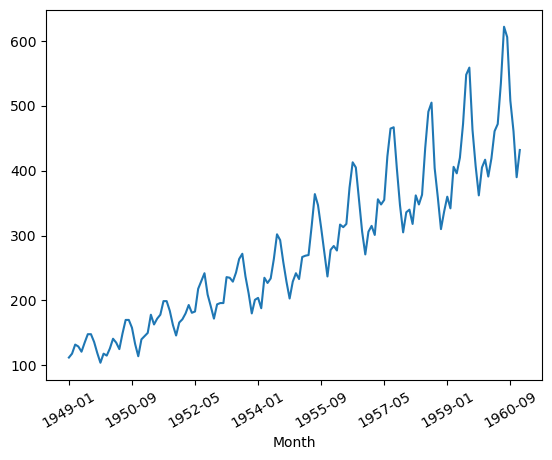

In [17]:
# 繪圖
df = df.set_index('Month')
df.plot(legend=None)
plt.xticks(rotation=30)
plt.show()

In [39]:
# 轉換資料
from sklearn.preprocessing import MinMaxScaler

# 函數：以前期資料為 X，當前期資料為 Y
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

dataset = df.values
dataset = dataset.astype('float32')

# X 常態化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# 資料分割
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# 以前期資料為 X，當期資料為 Y
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# 轉換為三維 [筆數, 落後期數, X維度]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [40]:
# 訓練模型
model = Sequential()
model.add(Input((1, look_back)))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

# 模型評估
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0586
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0222  
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0160    
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0141
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0136
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0106
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0083
Epoch 13/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0101  
Epoch 14/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070   
Epoch 15/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 

Train Score: 22.90 RMSE
Test Score: 47.62 RMSE


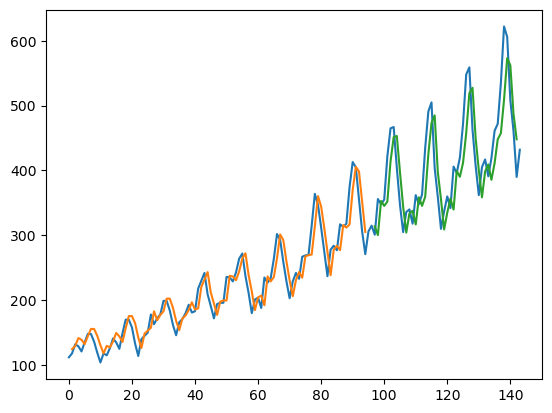

In [41]:
from sklearn.metrics import mean_squared_error
import math 

# 還原常態化的訓練及測試資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# 繪圖
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## 改變Loopback=3：X由前1期改為前3期 

In [43]:
# 載入測試資料
df = pd.read_csv('../nlp_data/airline-passengers.csv', usecols=[1])
print(df.head())
dataset = df.values
dataset = dataset.astype('float32')

# X 常態化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# 資料分割
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# 以前期資料為 X，當前期資料為 Y
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# 轉換為三維 [筆數, 落後期數, X維度]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

   Passengers
0         112
1         118
2         132
3         129
4         121


In [44]:
trainX.shape

(92, 1, 3)

In [45]:
# 訓練模型
model = Sequential()
model.add(Input((1, look_back)))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

# 模型評估
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1368   
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0424    
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0224
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0206
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166  
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0199
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0155
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0121
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0096
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0094
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086
Epoch 13/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0080
Epoch 14/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0074
Epoch 15/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

Train Score: 21.81 RMSE
Test Score: 63.87 RMSE


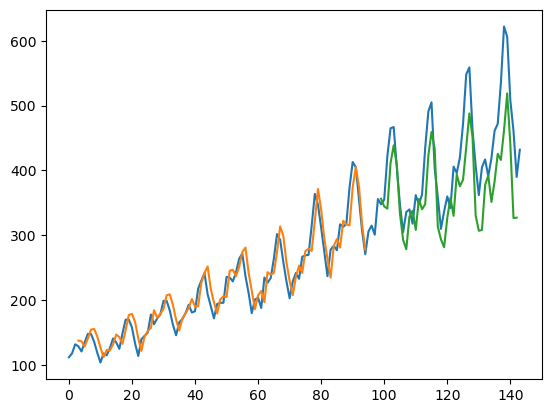

In [25]:
from sklearn.metrics import mean_squared_error
import math 

# 還原常態化的訓練資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# 繪圖
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## 改採Time Steps

In [46]:
# 載入測試資料
df = pd.read_csv('../nlp_data/airline-passengers.csv', usecols=[1])

dataset = df.values
dataset = dataset.astype('float32')

# X 常態化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# 資料分割
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# 以前期資料為 X，當前期資料為 Y
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# 轉換為三維 [筆數, 落後期數, X維度]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [27]:
trainX.shape

(92, 3, 1)

In [47]:
# 訓練模型
model = Sequential()
# (1, look_back) 改為 (look_back, 1)
model.add(Input((look_back, 1)))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

# 模型評估
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0433
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104   
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075   
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0061
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0056
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0057
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0038   
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042   
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032   
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042     
Epoch 13/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037
Epoch 14/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0043   
Epoch 15/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

Train Score: 26.33 RMSE
Test Score: 68.05 RMSE


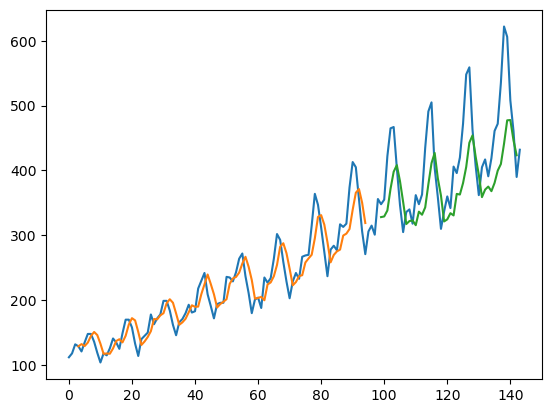

In [29]:
from sklearn.metrics import mean_squared_error
import math 

# 還原常態化的訓練資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# 繪圖
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## stateful=True

In [57]:
# 載入測試資料
df = pd.read_csv('../nlp_data/airline-passengers.csv', usecols=[1])

dataset = df.values
dataset = dataset.astype('float32')

# X 常態化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# 資料分割
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# 以前期資料為 X，當前期資料為 Y
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# 轉換為三維 [筆數, 落後期數, X維度]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [59]:
# 訓練模型
model = Sequential()
# (1, look_back) 改為 (look_back, 1)
batch_size = 1
model.add(InputLayer(batch_input_shape=(batch_size, look_back, 1)))
model.add(LSTM(4, stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, 
              shuffle=False, verbose=2)
    # 重置狀態(cell state)
    model.reset_metrics()

# 模型評估
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_metrics()
testPredict = model.predict(testX, batch_size=batch_size)

92/92 - 1s - 12ms/step - loss: 0.0326
92/92 - 0s - 1ms/step - loss: 0.0228
92/92 - 0s - 1ms/step - loss: 0.0225
92/92 - 0s - 1ms/step - loss: 0.0203
92/92 - 0s - 1ms/step - loss: 0.0184
92/92 - 0s - 1ms/step - loss: 0.0167
92/92 - 0s - 1ms/step - loss: 0.0151
92/92 - 0s - 1ms/step - loss: 0.0135
92/92 - 0s - 1ms/step - loss: 0.0120
92/92 - 0s - 1ms/step - loss: 0.0105
92/92 - 0s - 1ms/step - loss: 0.0092
92/92 - 0s - 1ms/step - loss: 0.0080
92/92 - 0s - 1ms/step - loss: 0.0071
92/92 - 0s - 1ms/step - loss: 0.0064
92/92 - 0s - 1ms/step - loss: 0.0059
92/92 - 0s - 1ms/step - loss: 0.0056
92/92 - 0s - 1ms/step - loss: 0.0054
92/92 - 0s - 1ms/step - loss: 0.0052
92/92 - 0s - 1ms/step - loss: 0.0051
92/92 - 0s - 1ms/step - loss: 0.0049
92/92 - 0s - 1ms/step - loss: 0.0048
92/92 - 0s - 1ms/step - loss: 0.0048
92/92 - 0s - 1ms/step - loss: 0.0047
92/92 - 0s - 1ms/step - loss: 0.0046
92/92 - 0s - 1ms/step - loss: 0.0045
92/92 - 0s - 1ms/step - loss: 0.0045
92/92 - 0s - 1ms/step - loss: 0.0044


Train Score: 24.86 RMSE
Test Score: 48.44 RMSE


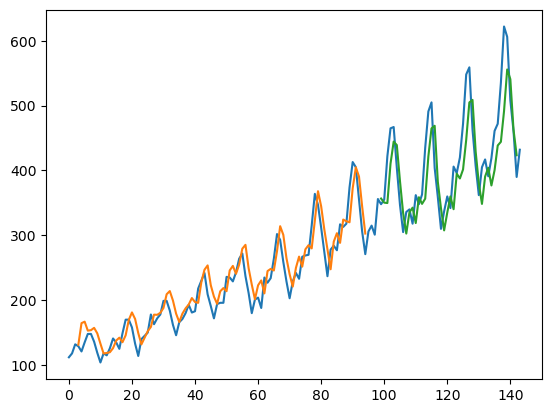

In [60]:
from sklearn.metrics import mean_squared_error
import math 

# 還原常態化的訓練資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# 繪圖
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Stacked LSTM

In [61]:
# 載入測試資料
df = pd.read_csv('../nlp_data/airline-passengers.csv', usecols=[1])
dataset = df.values
dataset = dataset.astype('float32')

# X 常態化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# 資料分割
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# 以前期資料為 X，當前期資料為 Y
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# 轉換為三維 [筆數, 落後期數, X維度]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [66]:
# 訓練模型
model = Sequential()
# (1, look_back) 改為 (look_back, 1)
# model.add(LSTM(4, input_shape=(look_back, 1)))
batch_size = 1

# Stacked LSTM
model.add(InputLayer(batch_input_shape=(batch_size, look_back, 1)))
model.add(LSTM(4, stateful=True, return_sequences=True))
model.add(LSTM(4, stateful=True))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, 
              shuffle=False, verbose=2)
    # 重置狀態(cell state)
    model.reset_metrics()

# 模型評估
trainPredict = model.predict(trainX, batch_size=batch_size)
# 重置狀態(cell state)
model.reset_metrics() 
testPredict = model.predict(testX, batch_size=batch_size)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Train Score: 23.12 RMSE
Test Score: 62.89 RMSE


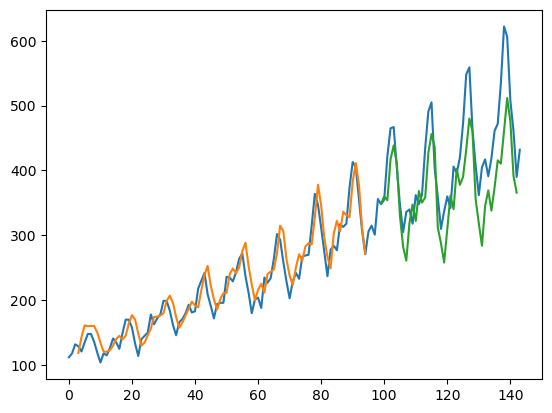

In [67]:
from sklearn.metrics import mean_squared_error
import math 

# 還原常態化的訓練資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# 繪圖
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()